In [1]:
import os
import cv2
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

DATA_DIR = 'data'

### Get predictions

In [2]:
# Load predictions
train_preds = [i[0] for i in np.load(os.path.join(DATA_DIR, 'train_preds.npy'))]
test_preds = [i[0] for i in np.load(os.path.join(DATA_DIR, 'test_preds.npy'))]

# Load ground truth
train_labels = np.loadtxt(os.path.join(DATA_DIR, 'train.txt'))

print('Training labels:', len(train_labels))
print('Training preds:', len(train_preds))

Training labels: 20400
Training preds: 20384


In [3]:
mean_squared_error(train_labels[:20384], train_preds)

1.5893359627566064

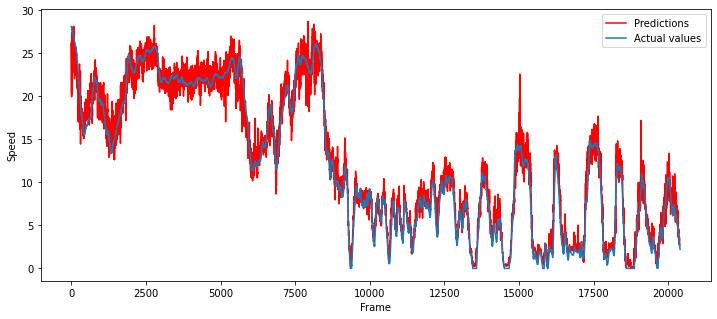

In [16]:
plt.figure(figsize=(12,5))
plt.plot(train_preds, 'r-', label='Predictions')
plt.plot(train_labels, label='Actual values')
plt.xlabel('Frame')
plt.ylabel('Speed')
plt.legend()
plt.show()

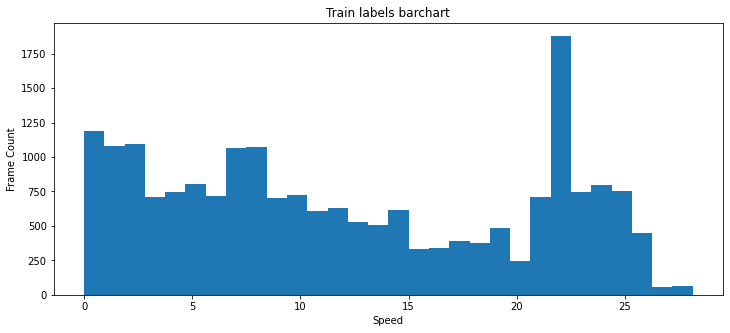

In [5]:
plt.figure(figsize=(12, 5))
plt.hist(train_labels, bins=30)
plt.xlabel('Speed')
plt.ylabel('Frame Count')
plt.title('Train labels barchart')
plt.show()

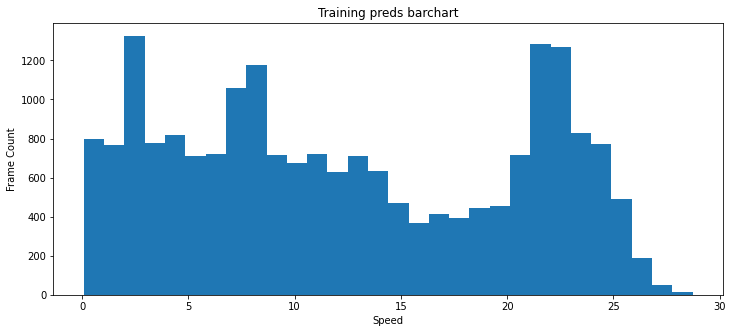

In [6]:
plt.figure(figsize=(12, 5))
plt.hist(train_preds, bins=30)
plt.xlabel('Speed')
plt.ylabel('Frame Count')
plt.title('Training preds barchart')
plt.show()

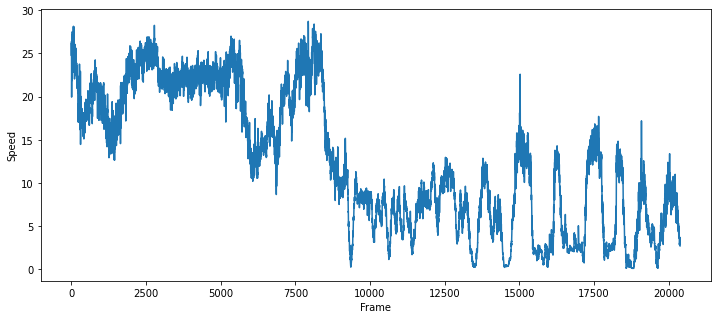

In [7]:
plt.figure(figsize=(12,5))
plt.plot(train_preds)
plt.xlabel('Frame')
plt.ylabel('Speed')
plt.show()

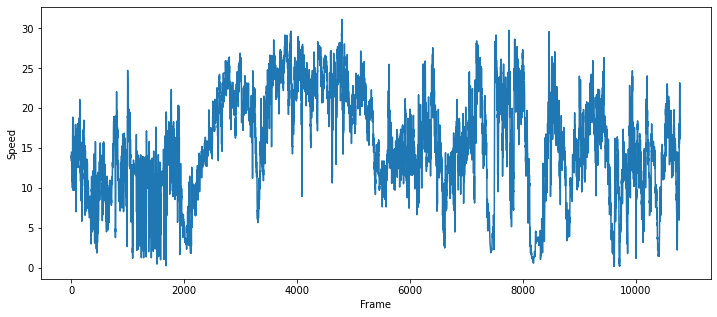

In [8]:
plt.figure(figsize=(12,5))
plt.plot(test_preds)
plt.xlabel('Frame')
plt.ylabel('Speed')
plt.show()

## Exponentially weighted moving average

To smooth out the predictions we apply an exponentially weighted average. This is taken over the last 20 frames, equivalent to one second. 

In [9]:
train_df = pd.DataFrame(train_preds, columns=['speed'])
train_df['EMA'] = train_df['speed'].ewm(span=20).mean()

train_df.describe()

,speed,EMA
count,20384.000000,20384.000000
mean,12.558781,12.568792
std,7.909684,7.871105
min,0.086465,0.095280
25%,5.708830,5.777123
50%,11.468145,11.461747
75%,20.871331,21.112384
max,28.723633,27.103279


In [10]:
speed_mse = mean_squared_error(train_labels[:20384], train_df['speed'])
ema_mse = mean_squared_error(train_labels[:20384], train_df['EMA'])

print(f'Training set original MSE: {speed_mse:.2f}')
print(f'With EMA: {ema_mse:.2f}')

Training set original MSE: 1.59
With EMA: 1.08


In [11]:
test_df = pd.DataFrame(test_preds, columns=['speed'])
test_df['EMA'] = test_df['speed'].ewm(span=20).mean()

test_df.describe()

,speed,EMA
count,10784.000000,10784.000000
mean,15.369330,15.365906
std,6.377011,5.947157
min,0.165123,0.872596
25%,11.143161,11.116645
50%,15.035848,14.983850
75%,20.517829,20.292278
max,31.146421,28.022751


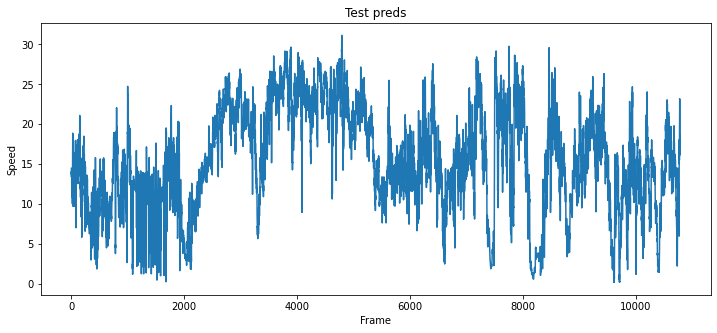

In [17]:
plt.figure(figsize=(12,5))
plt.plot(test_df['speed'])
plt.xlabel('Frame')
plt.ylabel('Speed')
plt.title('Test preds')
plt.show()

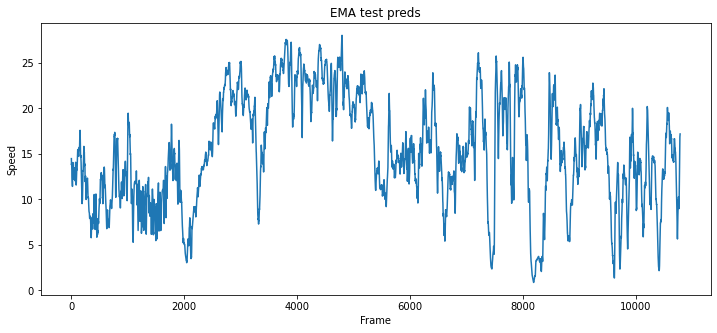

In [18]:
plt.figure(figsize=(12,5))
plt.plot(test_df['EMA'])
plt.xlabel('Frame')
plt.ylabel('Speed')
plt.title('EMA test preds')
plt.show()

### Create videos

Uncomment the cells below to create videos displaying predictions. 

In [14]:
img_array = []
for i in range(5000):
    img = cv2.imread(os.path.join(DATA_DIR, f'training_images/{i}.jpg'))
    
    pred = round(train_preds[i], 3)
    actual = round(train_labels[i], 3)
    error = round((actual - pred)**2, 3)
    # Add text
    font = cv2.FONT_HERSHEY_SIMPLEX 
    cv2.putText(img, f'Pred. speed: {pred}',
                (50, 50), font, 1, (255,255,255), 2,cv2.LINE_AA)
    cv2.putText(img, f'Actual speed: {actual}',
                (50, 100), font, 1, (255,255,255), 2,cv2.LINE_AA)
    cv2.putText(img, f'Error: {error}',
                (50, 150), font, 1, (255,255,255), 2,cv2.LINE_AA)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
out = cv2.VideoWriter('train_video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [15]:
img_array = []

for i in range(5000):
    img = cv2.imread(f'data/test_images/{i}.jpg')
    
    pred = round(test_preds[i], 3)
    # Add text
    font = cv2.FONT_HERSHEY_SIMPLEX 
    cv2.putText(img, f'Pred. speed: {pred}',
                (50, 50), font, 1, (255,255,255), 2,cv2.LINE_AA)
    
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('test_video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()